In [ ]:
#plotter per unire più run e più posterior
#------------------Import--------------------------------
import numpy as np
#import healpy as hp
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import os 
import statistics as stat
from multiprocessing import Pool
import multiprocessing
from tqdm import tqdm
folder='/home/rciancarella/DarkSirensStat/MyDSStat/results/'
#folder='/home/raul/DarkSirensStat/MyDSStat/results/'
os.chdir(folder)

# Data

In [2]:
runpath='0F_fullexplorer-02'#'Mega450-FullBig_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)
dscat = pd.read_csv(runpath + '_DSs.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
dscat.columns=colnames
os.chdir(datapath)
all_dls=np.loadtxt(runpath+'_DSs.txt', usecols=6)#if there is scattering
all_true_dls=np.loadtxt(runpath+'_DSs.txt', usecols=2)
all_zs=np.loadtxt(runpath+'_DSs.txt', usecols=3)
dl_max=np.max(all_dls)
dl_min=np.min(all_dls)
#----------------------------------beta
os.chdir(datapath)
x=np.loadtxt(runpath+'_H0grid.txt')
xmin=np.min(x)
xmax=np.max(x)
#betavol=np.loadtxt('/home/rciancarella/DarkSirensStat/MyDSStat/results/volbeta/betatest_beta.txt')
betatest=np.loadtxt(runpath+'_beta.txt')
#singlebeta=np.loadtxt(runpath+'_singlebeta.txt')
singlebeta=np.loadtxt(runpath+'_singlebeta.txt')

Catalogo Galassie

In [3]:
ref_folder='/home/rciancarella/DarkSirensStat/MyDSStat/'
cat_name='FullExplorer_big.txt'#FullExplorer_big.txt
#datapath=os.path.join(ref_folder,cat_name)
os.chdir(ref_folder)

Uniform_Cat = pd.read_csv(cat_name, sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
Uniform_Cat.columns=colnames
dlmaxcat=Uniform_Cat['scattered DL'].max()
dlmincat=Uniform_Cat['scattered DL'].min()
allz=Uniform_Cat['z']

# Posterior

In [4]:
os.chdir(datapath)
likes=np.loadtxt(runpath +'_fullrun.txt')
NDS=np.shape(likes)[0]
#mybeta=np.loadtxt('/home/rciancarella/DarkSirensStat/MyDSStat/results/MyBeta/MyBeta_beta.txt')

In [5]:
NDS=np.shape(likes)[0]
final_post_by_like=[]
for i in range(NDS):
    final_post_by_like.append(likes[i]/betatest[i])
#final_post_by_like.pop(210)
combined=[]
for i in range(len(final_post_by_like)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_by_like[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_by_like[i]*1))
        combined.append(num)
totpost_like=combined[-1]
all_norm_post=[]
for i in range(NDS):
    post=likes[i]/betatest[i]
    post=post/np.trapz(post,x)
    all_norm_post.append(post)

Text(0.75, 0.7, 'Std=2.70')

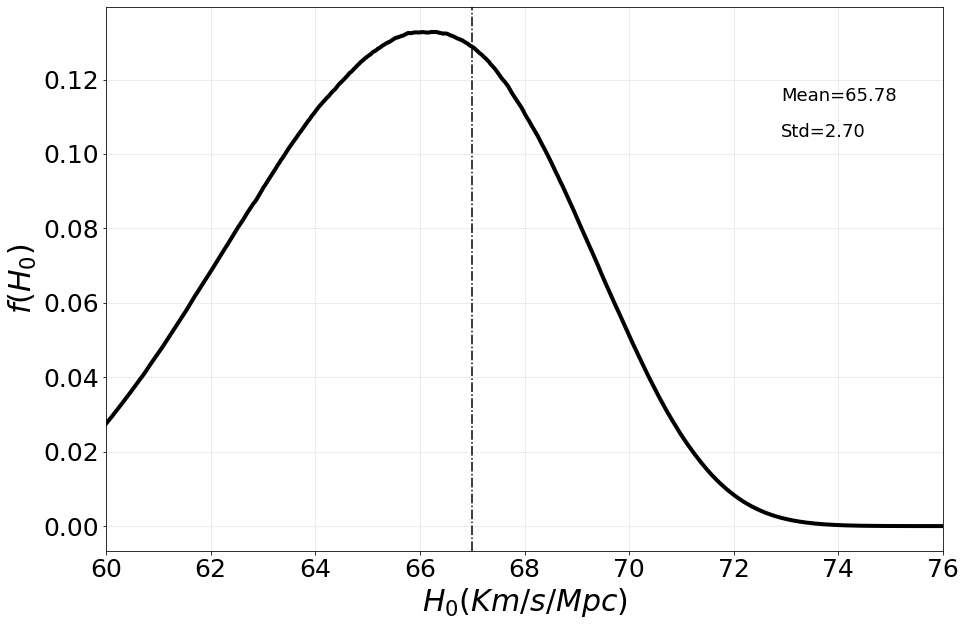

In [6]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$f(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')


ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color='k',linewidth=4,linestyle='solid')
newdist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.75,'Mean={:0.2f}'.format(mean),fontsize=18,c='k')
plt.figtext(0.75,0.70,'Std={:0.2f}'.format(std),fontsize=18, c='k')

# More Betas

In [7]:
from astropy.cosmology import FlatLambdaCDM
from scipy.optimize import fsolve
from numba import njit
#import numba_special
import multiprocessing
from scipy import special
#-----------------------Costants-----------------------------------------
href=67 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
#cosmoflag = FlatLambdaCDM(H0=href, Om0=Om0GLOB)

#H0min=60#30
#H0max=76#140
#H0Grid=np.linspace(H0min,H0max,1000)
mydlmax=10_700#Dl_z(zds_max,href,Om0GLOB)
mydlmin=8_350#Dl_z(zds_min,href,Om0GLOB)
z_sup=Uniform_Cat['z'].max()
z_inf=Uniform_Cat['z'].min()
datatmp=Uniform_Cat[(Uniform_Cat['scattered DL']>=mydlmin) &(Uniform_Cat['scattered DL']<=mydlmax)]
myallz=datatmp['z']
myallz=np.asarray(myallz)
@njit
def E_z(z, H0, Om=Om0GLOB):
    return np.sqrt(Om*(1+z)**3+(1-Om))

def r_z(z, H0, Om=Om0GLOB):
    c = clight
    integrand = lambda x : 1/E_z(x, H0, Om)
    integral, error = integrate.quad(integrand, 0, z)
    return integral*c/H0

def Dl_z(z, H0, Om=Om0GLOB):
    return r_z(z, H0, Om)*(1+z)
def volume(h,dl):
    cosmo=FlatLambdaCDM(H0=h,Om0=Om0GLOB)
    z=z_from_dl(h,dl)
    vol=cosmo.comoving_volume(z).value
    return vol

def z_from_dl(h,dl):
    func = lambda z :Dl_z(z, h, Om0GLOB) -dl
    zmax = fsolve(func, 0.02)[0] 
    return zmax

def beta_mod(h,dlmin,dlmax,zsup=z_sup,zinf=z_inf):
    cosmo=FlatLambdaCDM(H0=h,Om0=Om0GLOB)
    zmax=z_from_dl(h,dlmax)
    zmin=z_from_dl(h,dlmin)
    v_sup=cosmo.comoving_volume(zsup).value
    v_inf=cosmo.comoving_volume(zinf).value
    denom=v_sup-v_inf
    if zmax<=zsup:
        v_max=cosmo.comoving_volume(zmax).value
    else:
        v_max=v_sup
    if zmin>=zinf:
        v_min=cosmo.comoving_volume(zmin).value
    else:
        v_min=v_inf
    tmp=(v_max-v_min)/(v_sup-v_inf)
    return tmp

s=0.01
def beta_erf(h):
    mymu=Dl_z(zz,h)
    res=0.5*(special.erfc((mymu-mydlmax)/(np.sqrt(2)*s*mymu))-special.erfc((mymu-mydlmin)/(np.sqrt(2)*s*mymu)))
    return res
def beta_erfdl(iterator):
    h=x[iterator]
    to_sum=np.zeros(len(myallz))
    for j in range(len(myallz)):
        #dl=FlatLambdaCDM(H0=Htemp, Om0=Om0GLOB).luminosity_distance(z_gals[j]).value
        dl = Dl_z(myallz[j], h)
        tmp=0.5*(special.erfc((dl-mydlmin)/(np.sqrt(2)*s*dl))-special.erfc((dl-mydlmax)/(np.sqrt(2)*s*dl)))
        to_sum[j]=tmp
    res=np.sum(to_sum)#*norm
    
    return res
def reverse_betaerf(iterator):
    zz=myallz[iterator]
    to_sum=np.zeros(len(x))
    for j in range(len(x)):
        #dl=FlatLambdaCDM(H0=Htemp, Om0=Om0GLOB).luminosity_distance(z_gals[j]).value
        dl = Dl_z(zz, x[j])
        tmp=0.5*(special.erfc((dl-mydlmin)/(np.sqrt(2)*s*dl))-special.erfc((dl-mydlmax)/(np.sqrt(2)*s*dl)))
        to_sum[j]=tmp
    return to_sum



In [8]:
def calculate_to_sum(args):
    z, x, mydlmin, mydlmax, s = args
    to_sum = np.zeros(len(x))
    for j in range(len(x)):
        dl = Dl_z(z, x[j])
        tmp = 0.5 * (special.erf((dl - mydlmin) / (np.sqrt(2) * s * dl)) - special.erf((dl - mydlmax) / (np.sqrt(2) * s * dl)))
        to_sum[j] = tmp
    return to_sum

def calculate_res(myallz, x, mydlmin, mydlmax, s):
    res = np.zeros(len(x))
    with Pool(processes=15) as pool:  # Adjust the number of processes as needed
        to_sum_list = list(tqdm(pool.imap(calculate_to_sum, [(z, x, mydlmin, mydlmax, s) for z in myallz]), total=len(myallz)))
    for to_sum in to_sum_list:
        res += to_sum
    return res




In [9]:
beta_plot=[]

for h in x:
    beta_plot.append(beta_mod(h,mydlmin,mydlmax))
beta_plot=np.asarray(beta_plot)

In [ ]:
z_tosum=[]
#arr=np.arange(0,len(x),dtype=int)
with Pool(15) as p, tqdm(total=len(myallz)) as pbar:
    beta_guide=p.map(reverse_betaerf, range(len(myallz)))
    z_tosum.append(beta_guide)
    pbar.update(len(x))

In [ ]:
myallz=allz#[0:300_000]
result = calculate_res(myallz, x, mydlmin, mydlmax, s)
print(np.shape(result))

In [ ]:
print(result)

In [10]:
#np.savetxt('betaerf_unif_fullbig.txt',result)
galaxybeta=np.loadtxt('betaerf_unif_fullbig.txt')

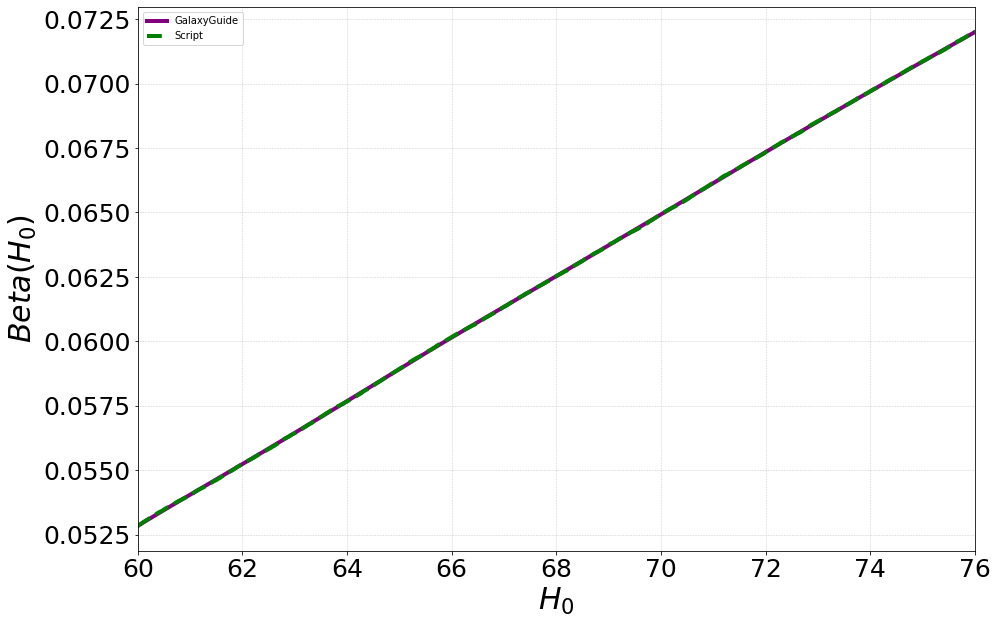

In [17]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(np.min(x), np.max(x))
ax.set_xlabel(r'$H_0$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Beta(H_0)$', fontsize=30)
ax.plot(x,galaxybeta/np.trapz(galaxybeta,x),color='purple',label='GalaxyGuide',linewidth=4,linestyle='solid')
ax.plot(x,singlebeta/np.trapz(singlebeta,x),color='g',label='Script',linewidth=4,linestyle='dashed')
ax.legend()

# Change Beta

In [ ]:
NDS=np.shape(likes)[0]
Changed=[]
for i in range(NDS):
    Changed.append(likes[i]/result)
#final_post_by_like.pop(210)
combined=[]
for i in range(len(Changed)):
    #combined=combined+post[i]
    if i==0:
        combined.append(Changed[i]*1)
    else:
        num=np.float128(combined[i-1]*(Changed[i]*1))
        combined.append(num)
totpost_Changed=combined[-1]

In [ ]:
NDS=np.shape(likes)[0]
single=[]
for i in range(NDS):
    single.append(likes[i]/singlebeta)
#final_post_by_like.pop(210)
combined=[]
for i in range(len(single)):
    #combined=combined+post[i]
    if i==0:
        combined.append(single[i]*1)
    else:
        num=np.float128(combined[i-1]*(single[i]*1))
        combined.append(num)
totpost_single=combined[-1]

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$f(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')


ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color='k',linewidth=4,linestyle='solid')
ax.plot(x,totpost_Changed/np.trapz(totpost_Changed,x),label='Post-betavol',color='purple',linewidth=4,linestyle='solid')
ax.plot(x,totpost_single/np.trapz(totpost_single,x),label='Post-betavol',color='purple',linewidth=4,linestyle='solid')
ax.legend(fontsize=13, ncol=2)   

newdist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c='k')
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c='k')

newdist=(totpost_Changed)/np.trapz(totpost_Changed,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.45,'Mean={:0.2f}'.format(mean),fontsize=18,c='purple')
plt.figtext(0.75,0.40,'Std={:0.2f}'.format(std),fontsize=18, c='purple')